<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">COMP5611M - Building a Machine Learning Pipeline</span> by <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Marc de Kamps and University of Leeds</span> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

# Building a Machine Learning Pipeline (Part 1)

## Introduction

This notebook is a recreation of Chapter 2 of the book *Hands-on Machine Learning with Scikit-Learn & Tensorflow*, first edition 2017, (There is a second edition), with adaptations to make the code run on the current *scikit-learn* interface. The dataset contains of house prices, geographical information, income of the home owner and some information about the house. The objective is to predict  the price of a new object, when information becomes available.

This dataset features in a number of machine learning textbooks and therefore will probably be used as an example for years to come, even if some aspects look slightly dated. For example, a house price of 500k USD does not look especially opulent by today's standard but this is the cap in this dataset, as, apparently, it was judged that prices above that are too rare. The rate of inflation between 1994 and 2021 is 187%.

### Objectives

This set of notebook contains a complete example of a machine learning pipeline. The objectives in this notebook (Part 1) are:
- To download and unpack a realistic dataset
- To split the data into test and training sets, with and without stratification
- To explore the dataset and to disscover features that are potentially informative

In Part 2 we will
- Impute and clean our dataset
- Replace non-numeric information by numerical representations
- Use transformers and pipelines

In Part 3 we will
- Perform linear regression
- Use decision trees and random forests for comparison
- Perform cross validation and parameter search


In [1]:
import os
import urllib.request

local_path = 'datasets/housing'

if not os.path.isdir(local_path):
    os.makedirs(local_path)

housing_url = 'https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz'
urllib.request.urlretrieve(housing_url,os.path.join(local_path,'./housing.tgz'))


('datasets/housing/./housing.tgz', <http.client.HTTPMessage at 0x10ac8e828>)

In [2]:
import pandas as pd
import tarfile

housing_tgz=tarfile.open(os.path.join(local_path,'./housing.tgz'))
housing_tgz.extractall(path=local_path)
housing_tgz.close()

csv_path=os.path.join(local_path,'./housing.csv')
df = pd.read_csv(csv_path)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ac3b1d0>,
      dtype=object)

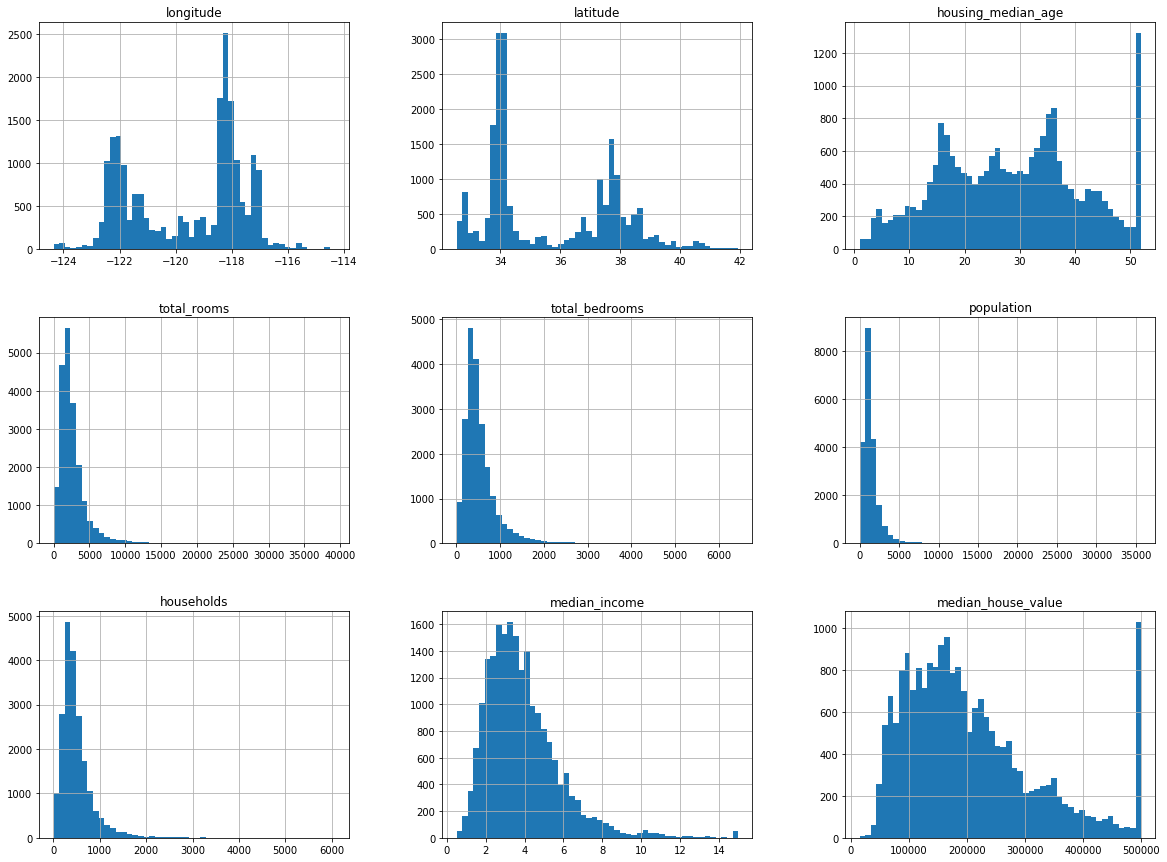

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

df.hist(bins=50,figsize=(20,15))

## Data cleaning and Imputation

The *'total bedrooms'* field seems to contain less data: 20433 records whereas the others contain 20640. This is presumably due to some data not being record, i.e. missing values. This is a common situation with most datasets, in particular healthcare records. The first thing to do is whether the data is in fact actually missing and in what form this is being recorded.

**Exercise 1**: Verify that there is missing data in the *'total_bedrooms'* column and explain how that is repesented.  Don't forget to check the csv file. What is a good way to represent missing values in Python?

In [5]:
# Sample Answer

print(df['longitude'].isnull().any())
print(df['total_bedrooms'].isnull().any())

import numpy as np

df[np.isnan(df['total_bedrooms'])]

False
True


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20267,-119.19,34.20,18.0,3620.0,NaN,3171.0,779.0,3.3409,220500.0,NEAR OCEAN
20268,-119.18,34.19,19.0,2393.0,NaN,1938.0,762.0,1.6953,167400.0,NEAR OCEAN
20372,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,410700.0,<1H OCEAN
20460,-118.75,34.29,17.0,5512.0,NaN,2734.0,814.0,6.6073,258100.0,<1H OCEAN


In [6]:
# df is a bit of a non-descriptive name. Chances are you are going to call all your dataframes df and will mix
# them up
housing = df

## Data interpretation

**Exercise 2**: Look at the median_income data. Do the numbers look like a realistic yearly income in dollars? 

### Imputation

Imputation is a complex subject. With decision trees, causal inference and generative models it is possible to perform imputation, the replacement of undefined values by 'sensible' ones. This requires a very good understanding of both the data and the models you're using. Traditionally, simpler methods have been used. In case where there is just a few missing values and the main objective is to prepare the data so that a machine learning pipeline does not choke on it, these methods are acceptable. They are broadly:

- Get rid of the rows that contain missing values

- Get rid of the entire attribute that contains missing values

- Set the values to some 'sensible'value, which can be the mean, the median, 0, 37 (for a temperature) etc.

## Creating Training and Test sets
Regardless of whether one performs regression or classification, to protect against overfitting it is necessary to split the data into a training and a test set.

You should create a test as early as possible. This means before further data analysis and data cleaning. So far you've received the data, inspected it to see whether it is roughly what you expect, but that should be all. You should not explore the test set.
One can simply set apart a random fraction of the dataset for test purposes, *and patterns from this test set should never be used in any training*.  In principle this is straightforward, but there are a number of subtleties that  you should be aware of.

**Exercise 3**: Design a function that splits the data into a training and test set. Make the ratio between the number of training and test patterns a customisable parameter. 

In [7]:
#! Sample answer as provided by Geron, which gives a good idea about how permutations can be used
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices],data.iloc[test_indices]

train_set, test_set = split_train_test(housing,0.2)
print(len(train_set))
print(len(test_set))

16512
4128


**Exercise 4** Look at the code below and explain why its results indicate that if you simply split the
dataset you may have a problem.

In [8]:
print(np.random.permutation(5))
print(np.random.permutation(5))

[1 4 2 0 3]
[1 2 4 0 3]


*Sample Answer* Your notebook will produce different results every time you run it. This is a problem if your analysis needs to be reproducible. You will want to show your boss the same results that you saw! You will want to be able to reproduce an analysis in a paper exactly in case reviewers ask questions about it. Etc.

**Exercise 5** Discuss potential fixes for this problem. The reproducibility problem has an easy fix. Describe it. A more subtle problem may arise if the dataset is updated every now and then.

**Exercise 6** Explain how the following code implies that even after prudently setting a random seed in order to obtain reproducibility, an expansion of your dataset kills reproducibility, even if the original dataset entries are kept in order and new data is appended (and not simply inserted in random places).

In [9]:
np.random.seed(42)
print(np.random.permutation(5))
np.random.seed(42)
print(np.random.permutation(5))
np.random.seed(42)
print(np.random.permutation(6))




[1 4 2 0 3]
[1 4 2 0 3]
[0 1 5 2 4 3]


The previous examples serve as warning that creating test and training set is not as straightforward as it may appear at first sight. In fact scikit-learn contains a train_test_split function, which has a *random_state* variable by which you can set the seed. Research its use.

In [10]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size= 0.3, random_state=42)

### Stratified Sampling for Training and Test set

Suppose you're investigating a new vaccine and that there are reasons to believe that it works differently for males and females. Now assume that you have to create a machine learning pipe line and that you need to investigate the potential different outcome of treatment with the vaccine.

If you create test and training sets as described, then on average it will create the same number of males and females in the test set as there are in the overall dataset. This is on average however! If the test set is relatively small there may be deviations of a few percent each time you repeat the test set generation. When investigating small effects that are potentially caused by biological differences it may be desirable to have test and training set split according to the ratio between males and females in the overall population. And this is not 50-50! The US population is 51.3% female and 48.7% and in other western countries this ratio will be similar.

If you randomly sample 1000 people from the overall population there is about 12% chance of creating a sample
where either less than 49%  or more than 53% of the sample is female. So without any precaution you may bias your sample towards males or females purely by chance. It is better to pick random samples that reflect the ration between males and females in the overall population. 

Dividing the overall population into homogeneous subgroups is called stratification; the subgroups are called strata. In stratified sampling the right number of samples is generated from each stratum to guarantee that the test set is representative.

We will show the potential for bias on the housing data.


#### An Example of Stratified Sampling for the Housing Dataset

Imagine talking to a domain expert who tells you that the median income is very important in predicting median house prices. For that reason you decide to create a test set that is representative of different income categories. Let's look at the median income again.

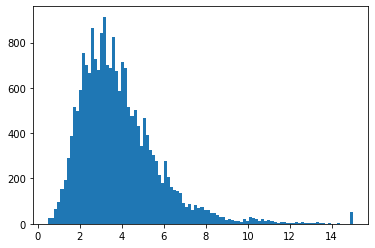

In [11]:
_=plt.hist(housing["median_income"],bins=100)

Let's assume that we want to create 5 income categories, that are each well populated. In order to be able
to develop categories we can use the *ceil* function which maps the floating point value to the next integer.


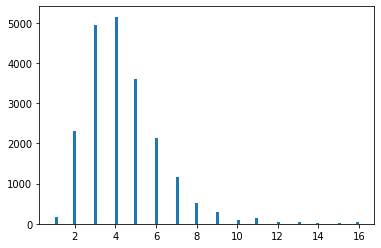

In [12]:
_=plt.hist(np.ceil(housing["median_income"]),bins=100)

That's a rather large number of categories. Moreover, the highest income bins are rather sparsely populated.

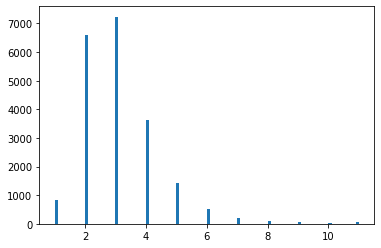

In [13]:
_=plt.hist(np.ceil(housing["median_income"]/1.5), bins=100)

That looks better. If we lump everything > 5 into one category (high income), then we have reasonable strata.  For the purpose of creating a representative test set we will first create an exta *income_category* column in our dataset.

In [14]:
housing["income_category"]=np.ceil(housing["median_income"]/1.5)
housing.head()



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_category
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0


Now we will create suitable bin boundaries so that each category gets its own bin and everything over 5 is lumped into a single 'high income category'.

In [15]:
bins= [0.0, 1.5, 2.5, 3.5, 4.5, 10]
countval=np.histogram(housing["income_category"], bins=bins)
print(countval)

(array([ 822, 6581, 7236, 3639, 2313]), array([ 0. ,  1.5,  2.5,  3.5,  4.5, 10. ]))


That looks sensible. Every category as of the order of 1k entries, but there is still a discernable difference. We are now going to replace the entries *income_category* with a value of 5.

In [16]:
housing["income_category"].where(housing["income_category"] < 5, 5.0, inplace = True)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_category
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0


Note the  *where* statement. Where the condition is fulfilled, the number is replaced by itself. Where the condition is not fulfilled it is being replaced by 5.0.  We can check the number of entries in each category:

In [17]:
housing["income_category"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_category, dtype: int64

Note that these are the same numbers as returned by the histogram, so this is independent validation that the categories work as intended. We can now create a test that is appropriately sampled from each category:

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=42)

for train_index, test_index in split.split(housing,housing["income_category"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

It is interesting to compare the percentages of each category in the stratisfied test set to the percentages in the full data set and then to do this for an unstratisfied test set, like the one we created earlier.

**Exercise 7** Perform this comparison.

In [19]:
#! Sample answer
print(housing["income_category"].value_counts()/len(housing))
print(strat_test_set["income_category"].value_counts()/len(strat_test_set))
# we must generate a new test set as the the category variable was not in the earlier one
train_set, test_set = train_test_split(housing, test_size= 0.3,random_state=42)
print(test_set["income_category"].value_counts()/len(test_set))

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_category, dtype: float64
3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_category, dtype: float64
3.0    0.353036
2.0    0.321867
4.0    0.170543
5.0    0.113695
1.0    0.040859
Name: income_category, dtype: float64


You are likely to have found that the relative error in the lowest category is considerable. If not, you were lucky and you should repeat the test.

It is prudent to restore the training and test set to their original state:

In [20]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop(("income_category"),axis=1,inplace=True)

## Exploring the Data

Before starting machine learning in earnest, it is a good idea to explore the data. You should do the exclusively on the training set. The test set should be "locked in a safe" until you actually start to evaluate how well your models perform. Therefore, create a copy of the training set:

In [21]:
housing=strat_train_set.copy() 
# Note that the stratified sets are now your main copy

It is easy to explore some of the geographical features.

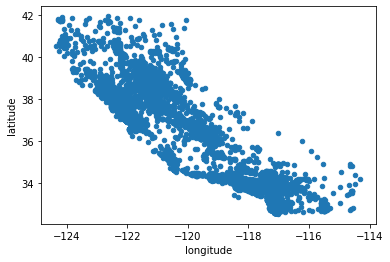

In [22]:
housing.plot(kind="scatter",x="longitude",y="latitude")

It is recognisably California, but not pretty. It is better to give the data points some transparency:

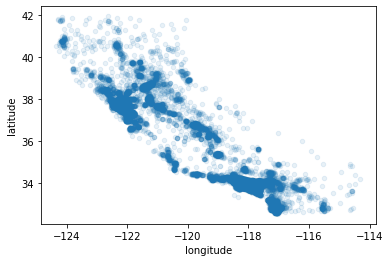

In [23]:
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.1)

This gives a better idea of which areas are densely populated. You can now plot different attributes of your dataset, for example the population size of the area where your house is located. A predefined colour map called jet is used to indicate house value, while the marker size indicates the population size of the area where the house is located:

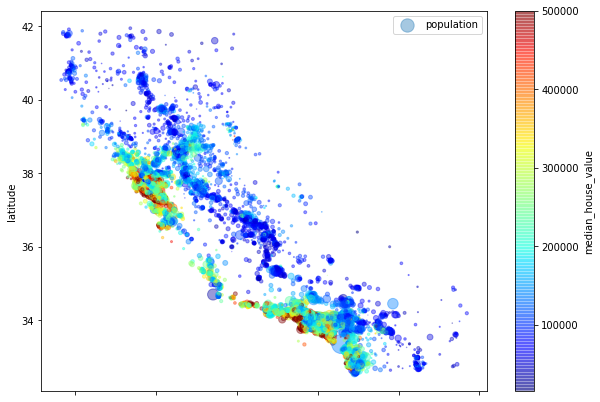

In [24]:
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.4,s=housing["population"]/100,label="population",
            figsize=(10,7),c="median_house_value",cmap=plt.get_cmap("jet"),colorbar=True)
plt.legend()

It is also useful to be able to draw scatter plots:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1ff92cc0>,
      dtype=object)

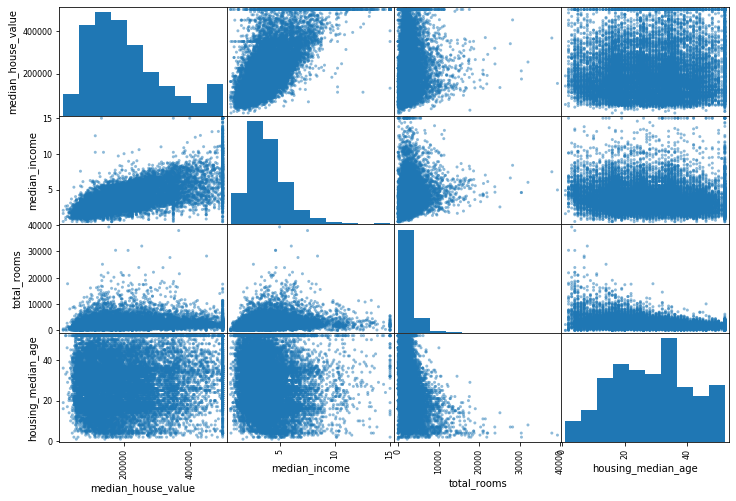

In [25]:
from pandas.plotting import scatter_matrix

attributes=["median_house_value","median_income","total_rooms","housing_median_age"]

scatter_matrix(housing[attributes],figsize=(12,8))

The single variable that correlates most clearly with *median_house_value* is *median_income*. Focussing on these data, we see:

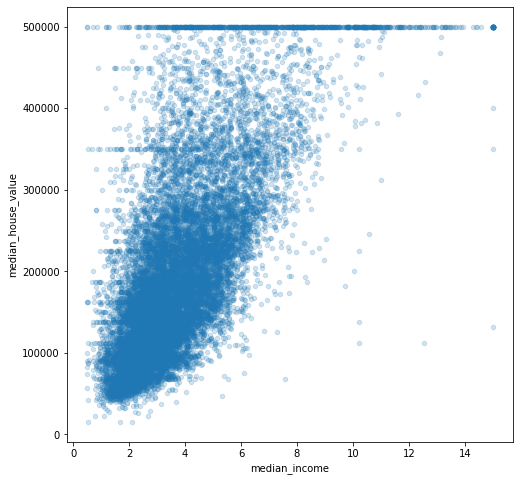

In [26]:
housing.plot(kind="scatter",x="median_income",y="median_house_value",alpha=0.2,figsize=(8,8))

- The correlation is quite strong
- The cap of 500k is clearly visible
- There are other horizontal lines e.g. at 350k

You may want to consider removing these data because they are artefacts. You want your model to learn the smooth distribution.

Some aspects of the dataset are somewhat weird. For example 'total rooms' is the total number of rooms per district. Hardly useful. It seems much more useful to calculate the number of rooms per household. Similarly, the ration between 'total bed rooms' and 'total rooms' seems much more useful than just the total number of bed rooms per district. It is not difficult to add these quantities to the dataset.

In [27]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

It is now interesting to look at the correlation between the median house value and other attributes:

In [28]:
corr_matrix=housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

This shows that median income indeed correlates strongly with the house value, and that the ratio of bed rooms over the total number of rooms is more informative than simply the number of bed rooms. Apparently a low ratio means that you have lots of rooms not necessary for sleeping, suggesting a more expensive house.